In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


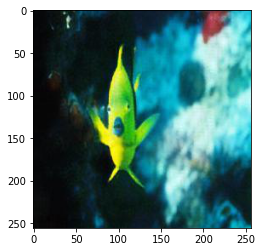

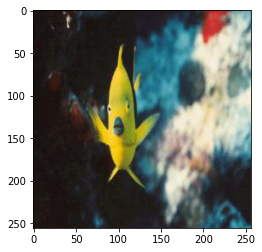

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


train_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

class ImageDataset(Dataset):
  def __init__(self, input_dir, clear_img_dir, transform ):
    #data loading
    self.filenames = os.listdir(input_dir)
    self.filenames = [os.path.join(input_dir, f) for f in self.filenames if f.endswith('.jpg')]
    self.filenames.sort()
    
    self.clear_img_file = os.listdir(clear_img_dir)
    self.clear_img_file =[os.path.join(clear_img_dir, f) for f in self.clear_img_file if f.endswith('.jpg')]
    self.clear_img_file.sort()
    #print(self.clear_img_file)
    #print(self.filenames)
    self.transform = transform


  def __getitem__(self, index):
    #dataset[0]
    input_image = Image.open(self.filenames[index])  # PIL image
    input_image = self.transform(input_image)

    clear_image = Image.open(self.clear_img_file[index])
    clear_image = self.transform(clear_image)
    return input_image, clear_image
    
  
  def __len__(self):
    #length(dataset)
    return len(self.filenames)

kunal_A = '/content/drive/MyDrive/Antahsagari/Paired/underwater_imagenet/trainA'
kunal_B = '/content/drive/MyDrive/Antahsagari/Paired/underwater_imagenet/trainB'
aakif_A = '/gdrive/MyDrive/Datasets/Paired/underwater_imagenet/trainA'
aakif_B = '/gdrive/MyDrive/Datasets/Paired/underwater_imagenet/trainB'
dataset = ImageDataset(aakif_A,aakif_B, train_transformer)



train_loader = DataLoader(dataset=dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
input_img, clear_img = dataiter.next()

#input_img = torch.reshape(input_img, (256,256,3,1))
#clear_img = torch.reshape(clear_img, (256,256,3,1))
# show images
imshow(torchvision.utils.make_grid(input_img))
imshow(torchvision.utils.make_grid(clear_img))

print(input_img.shape, clear_img.shape)


In [ ]:
import torch 
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp


def PreProcessing(input_img):
  #temp = torch.reshape(input_image, (256,256,3,1))
  temp = input_img
  #print(input_img.shape)
  #input_img = torch.reshape(input_image, (256,256,3,1))
  mu_i = torch.mean(temp, dim = (2,3), keepdim=True)
  #mu_i = torch.reshape(mu_i, (3,1))
  sigma_i = torch.std(temp, dim = (2,3), keepdim=True)
  # print(input_img.shape,mu_i.shape)
  I_centered = input_img.sub_(mu_i)
  mu_sigma_cat = torch.cat((mu_i, sigma_i), dim = 1)
  # print(mu_sigma_cat.shape)
  #print(mu_sigma_cat, '\n', mu_i, '\n', mu_sigma_cat.shape)
  #print(I_centered, I_centered.shape)
  return I_centered, mu_i, mu_sigma_cat



In [ ]:
# import numpy as np
# import torch
import torch.nn as nn
# import torch.nn.functional as F

# class GlobalNet(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size):
#     super(GlobalNet, self).__init__()
    
#     self.input_size = input_size
#     self.l1 = nn.Linear(input_size, hidden_size)
#     self.fc1 = nn.ReLU()
#     self.l2 = nn.Linear(hidden_size, hidden_size)
#     self.fc2 = nn.ReLU()
#     self.l3 = nn.Linear(hidden_size, hidden_size)
#     self.fc3 = nn.ReLU()
#     self.l4 = nn.Linear(hidden_size*3, output_size)

    
#   def forward(self, x):
#     out = self.l1(x)
#     h1 = self.fc1(out)
#     out = self.l2(h1)
#     h2 = self.fc2(out)
#     out = self.l3(h2)
#     h3 = self.l3(out)
#     # print("h3",h3.shape)
#     ct = torch.cat((h1,h2,h3), dim = 2 )
#     # print("concat global ",ct.shape)
#     delta_mu = self.l4(ct)
    
#     return delta_mu

# class LocalNet(nn.Module):
#   def __init__(self, bias, input_channels, num_channels, output_channels):
#     super(LocalNet, self).__init__()
#     self.bias = bias
#     self.l1 = nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding=1  ,bias = False) 
#     self.conv1 = nn.ReLU()
#     self.l2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding=1  ,bias = False)
#     self.conv2 = nn.ReLU()
#     self.l3 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding=1  ,bias = False)
#     self.conv3 = nn.ReLU()
#     self.l4 = nn.Conv2d(num_channels*3, output_channels,kernel_size=3, padding=1)

#   def forward(self, x):
#     #print("Local skip",x.shape,self.bias.shape)
    
#     out = self.l1(x) 
#     # print(out.shape)
#     out +=torch.reshape(self.bias,(16,1,1))
#     H1 = self.conv1(out)
#     out = self.l2(H1) + torch.reshape(self.bias,(16,1,1))
#     H2 = self.conv2(out)
#     out = self.l3(H2) + torch.reshape(self.bias,(16,1,1))
#     H3 = self.conv3(out)
#     J_centered = self.l4(torch.cat((H1,H2,H3), dim = 1))
#     #print("J_centered",J_centered.shape)
#     #J_centered+=torch.reshape(self.bias,(16,1,1))
#     return J_centered

class TotalNet(nn.Module):
  def __init__(self):
    super(TotalNet, self).__init__()
    self.bias_layer = nn.Linear(3, 16)

    #GLOBAL NET
    input_size =3
    hidden_size=16
    output_size=3
    self.gl1 = nn.Linear(input_size, hidden_size)
    self.fc1 = nn.ReLU()
    self.gl2 = nn.Linear(hidden_size, hidden_size)
    self.fc2 = nn.ReLU()
    self.gl3 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.ReLU()
    self.gl4 = nn.Linear(hidden_size*3, output_size)
    self.fc4 = nn.Sigmoid()

    #LOCAL_NET
    input_channels=3
    num_channels=16
    output_channels=3
    self.ll1 = nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding=1  ,bias = False) 
    self.conv1 = nn.ReLU()
    self.ll2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding=1  ,bias = False)
    self.conv2 = nn.ReLU()
    self.ll3 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding=1  ,bias = False)
    self.conv3 = nn.ReLU()
    self.ll4 = nn.Conv2d(num_channels*3, output_channels,kernel_size=3, padding=1)


  def forward(self, x):
    print("======================= Image ====================")
    imshow(torchvision.utils.make_grid(x.cpu().data))
    I_centered, mu_i, mu_sigma_cat = PreProcessing(x)
   
    print("======================= I-centered ====================")
    imshow(torchvision.utils.make_grid(I_centered.cpu().data))
    #print('mu_sigma_cat shape:',mu_sigma_cat.shape, 'mu_i shape :' , mu_i.shape)
    new = torch.reshape(mu_sigma_cat,(1,1,6))
    #trp = torch.transpose(new,1,2)
    mu_i = torch.reshape(mu_i,(1,1,3))


    """
    GLOBAL NET
    """
    # print(trp.shape)
    x=mu_i
    out = self.gl1(x)
    h1 = self.fc1(out)
    out = self.gl2(h1)
    h2 = self.fc2(out)
    out = self.gl3(h2)
    h3 = self.gl3(out)
    # print("h3",h3.shape)
    ct = torch.cat((h1,h2,h3), dim = 2 )
    # print("concat global ",ct.shape)
    delta_mu_i = self.gl4(ct)
    mu_final = self.fc4(delta_mu_i.add(mu_i))


    self.bias = self.bias_layer(delta_mu_i)
    # print("delta_mu :",delta_mu_i.shape)
    # print("mu :",mu_i.shape)
    


    """
    LOCAL NET
    """
    x=I_centered
    out = self.ll1(x) 
    # print(out.shape)
    out +=torch.reshape(self.bias,(16,1,1))
    H1 = self.conv1(out)
    out = self.ll2(H1) + torch.reshape(self.bias,(16,1,1))
    H2 = self.conv2(out)
    out = self.ll3(H2) + torch.reshape(self.bias,(16,1,1))
    H3 = self.conv3(out)
    J_centered = self.ll4(torch.cat((H1,H2,H3), dim = 1))
    print("======================= J_Centered ====================")
    imshow(torchvision.utils.make_grid(J_centered.cpu().data))

    #mu_final = torch.sigmoid(mu_i.add(delta_mu_i))
    # print("mu_final",mu_final.shape)
    J_final = J_centered.add(torch.reshape(mu_final,(3,1,1)))
    print("======================= JFINAL ====================")
    imshow(torchvision.utils.make_grid(J_final.cpu().data))
    
    print("mu_i",mu_i)
    print("delta_mui",delta_mu_i)
    print("mu_final",mu_final)

    

    return J_final



In [ ]:
from torchsummary import summary
model = TotalNet().to(device)
# globnet = GlobalNet(6,16,3)
# locnet = LocalNet(None,3,16,3)
alpha = 0.5
num_epochs = 40
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# print(model.parameters)
# print(globnet.parameters())
# print(locnet.parameters())
# #summary(globnet, (6,1), batch_size = -1)
#summary(locnet, (3,256,256), batch_size = -1)
#summary(model, (3,256,256), batch_size = -1)

# for name, param in model.named_parameters():
#   if param.requires_grad:
#       print(name, param.data)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])


7158

======================= Image ====================


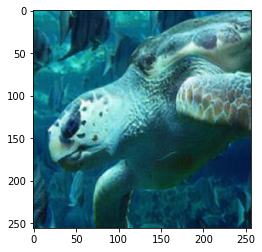

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


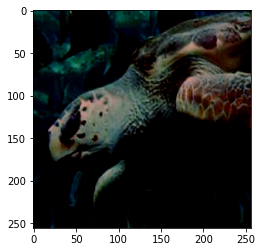

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


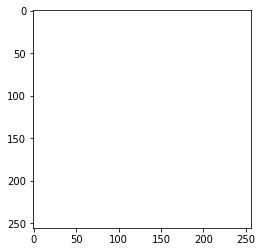

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


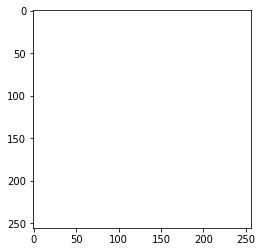

mu_i tensor([[[0.1713, 0.4109, 0.4520]]], device='cuda:0')
delta_mui tensor([[[0.8259, 0.9992, 1.1506]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7305, 0.8038, 0.8324]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
Epoch [1/40], Step [60/3700], Loss: 1.0002
======================= Image ====================


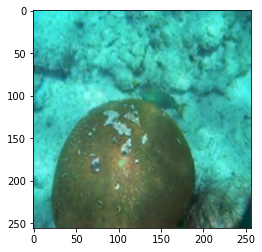

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


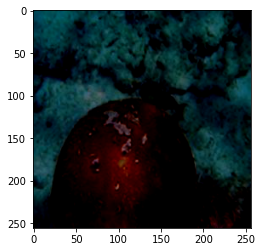

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


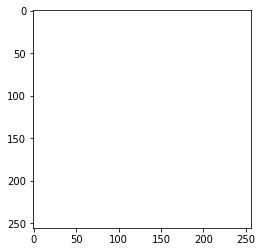

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


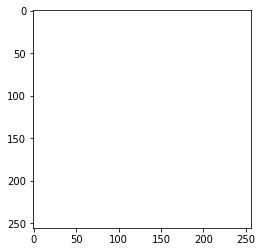

mu_i tensor([[[0.2626, 0.6083, 0.5384]]], device='cuda:0')
delta_mui tensor([[[0.9368, 1.0845, 1.2936]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7684, 0.8446, 0.8620]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


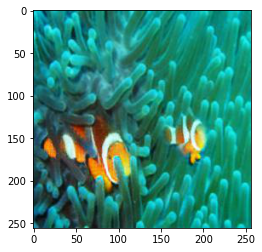

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


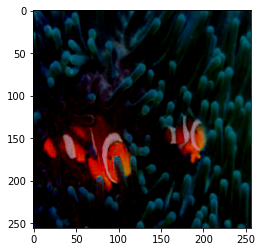

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


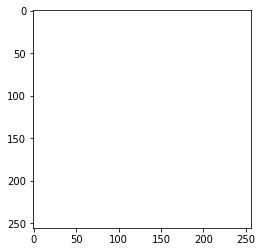

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


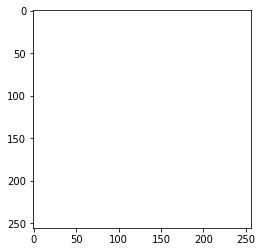

mu_i tensor([[[0.1480, 0.5153, 0.4435]]], device='cuda:0')
delta_mui tensor([[[0.9240, 1.0468, 1.2672]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7450, 0.8267, 0.8469]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


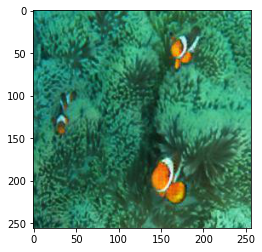

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


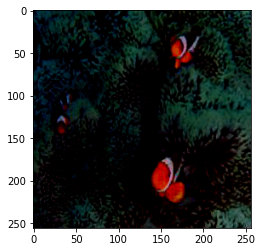

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


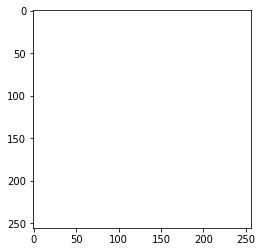

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


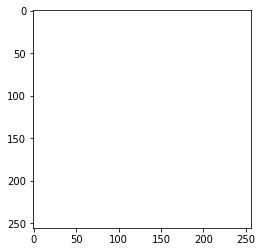

mu_i tensor([[[0.1966, 0.4706, 0.3471]]], device='cuda:0')
delta_mui tensor([[[0.9111, 1.0345, 1.2981]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7517, 0.8183, 0.8382]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


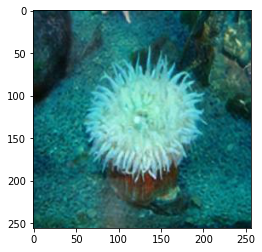

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


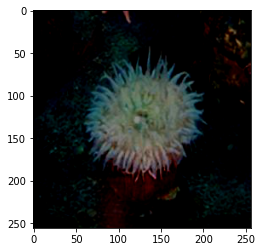

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


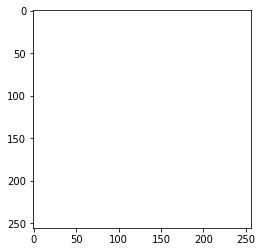

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


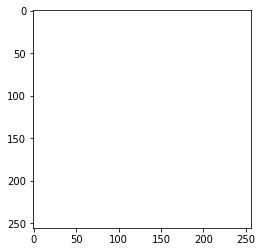

mu_i tensor([[[0.1805, 0.4443, 0.4428]]], device='cuda:0')
delta_mui tensor([[[0.9237, 1.0323, 1.3128]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7510, 0.8140, 0.8527]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


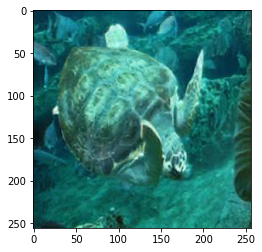

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


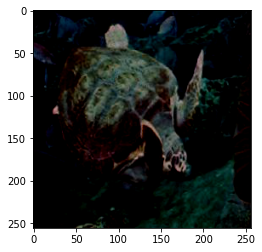

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


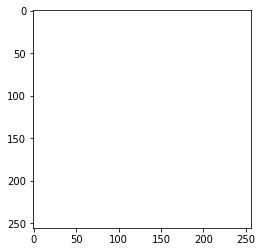

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


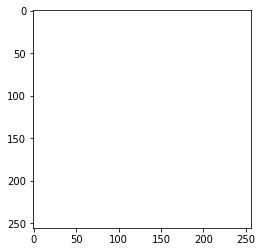

mu_i tensor([[[0.1477, 0.4535, 0.4285]]], device='cuda:0')
delta_mui tensor([[[0.9407, 1.0367, 1.3490]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7481, 0.8161, 0.8554]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


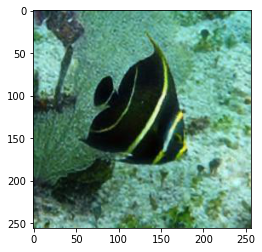

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


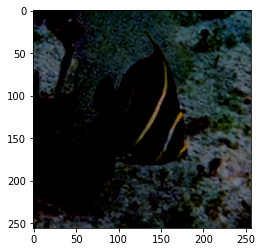

======================= J_Centered ====================


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


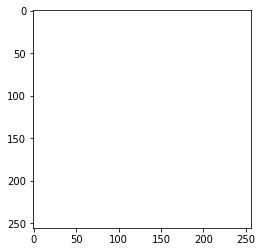

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


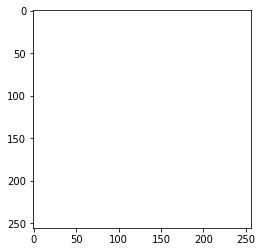

mu_i tensor([[[0.3344, 0.5165, 0.4336]]], device='cuda:0')
delta_mui tensor([[[0.9862, 1.0886, 1.4644]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7893, 0.8327, 0.8697]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


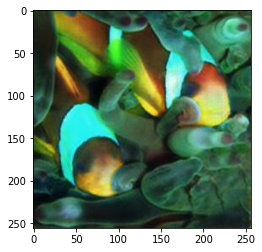

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


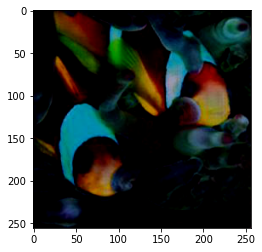

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


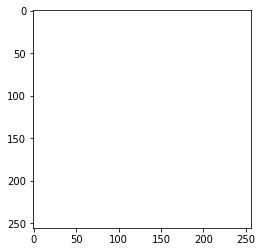

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


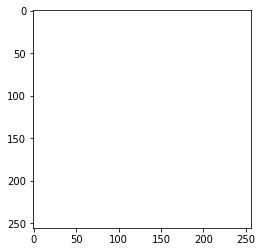

mu_i tensor([[[0.2501, 0.3959, 0.2676]]], device='cuda:0')
delta_mui tensor([[[0.9372, 1.0495, 1.4228]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7663, 0.8093, 0.8443]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


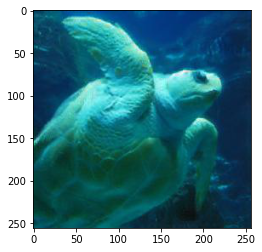

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


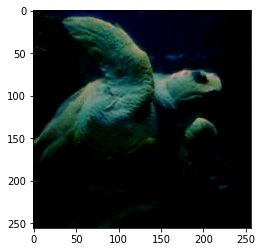

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


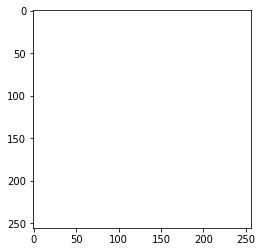

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


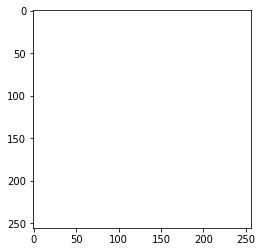

mu_i tensor([[[0.0690, 0.3593, 0.4139]]], device='cuda:0')
delta_mui tensor([[[0.9171, 1.0158, 1.3764]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7283, 0.7982, 0.8570]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


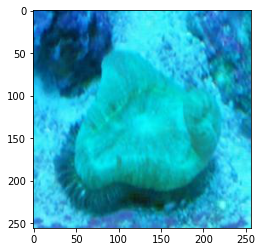

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


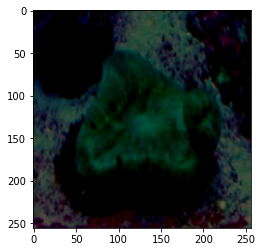

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


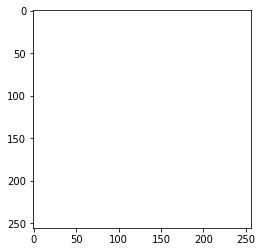

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


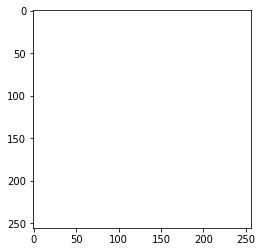

mu_i tensor([[[0.1015, 0.6474, 0.7519]]], device='cuda:0')
delta_mui tensor([[[1.0564, 1.1515, 1.5700]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7610, 0.8580, 0.9107]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


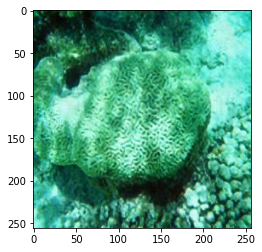

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


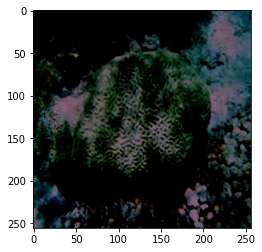

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


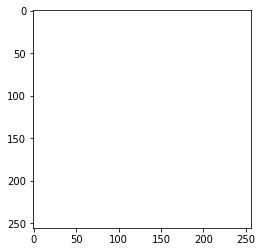

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


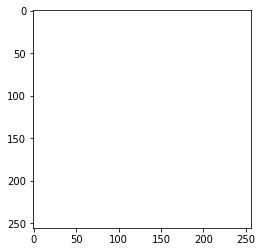

mu_i tensor([[[0.2586, 0.6067, 0.4799]]], device='cuda:0')
delta_mui tensor([[[1.0062, 1.1320, 1.6206]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7798, 0.8505, 0.8909]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


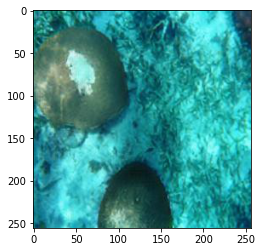

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


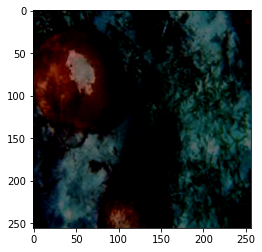

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


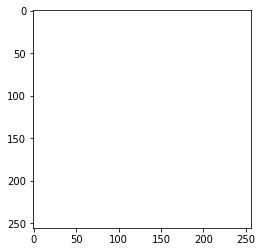

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


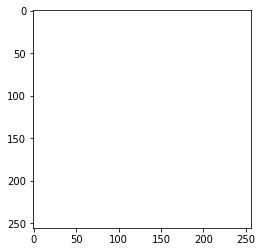

mu_i tensor([[[0.1822, 0.5740, 0.5674]]], device='cuda:0')
delta_mui tensor([[[0.9936, 1.1210, 1.6077]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7642, 0.8449, 0.8980]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


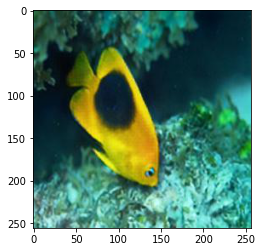

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


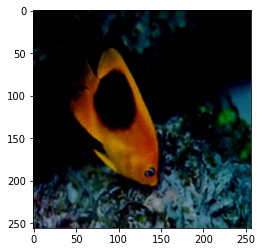

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


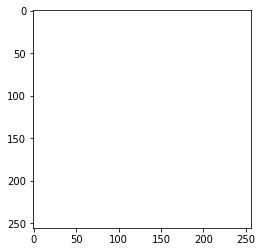

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


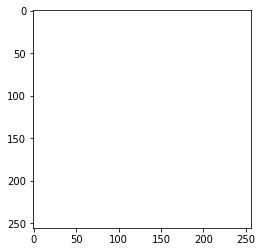

mu_i tensor([[[0.2263, 0.4230, 0.3251]]], device='cuda:0')
delta_mui tensor([[[0.9004, 1.0630, 1.5608]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7552, 0.8155, 0.8683]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


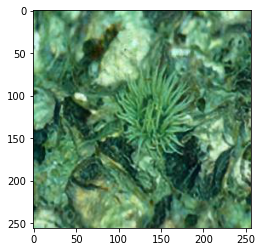

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


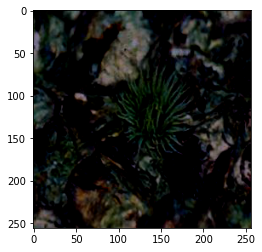

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


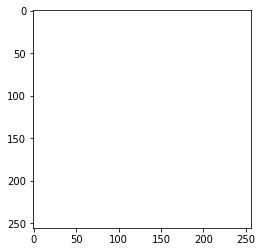

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


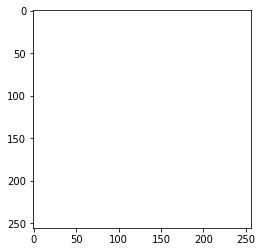

mu_i tensor([[[0.3310, 0.5157, 0.3733]]], device='cuda:0')
delta_mui tensor([[[0.9360, 1.1143, 1.6649]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7802, 0.8362, 0.8847]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


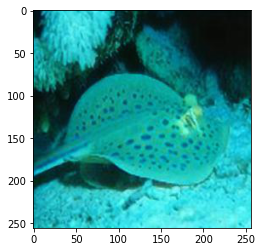

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


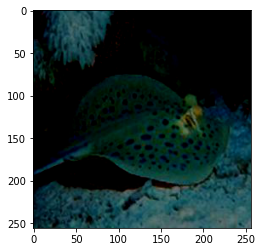

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


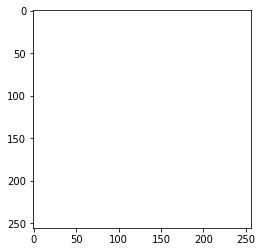

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= JFINAL ====================


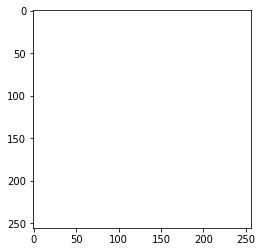

mu_i tensor([[[0.0931, 0.5318, 0.5274]]], device='cuda:0')
delta_mui tensor([[[0.9537, 1.1092, 1.6367]]], device='cuda:0', grad_fn=<AddBackward0>)
mu_final tensor([[[0.7402, 0.8377, 0.8970]]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
======================= Image ====================


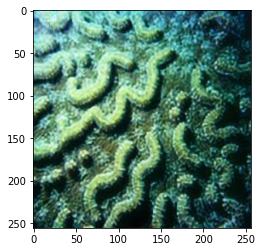

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= I-centered ====================


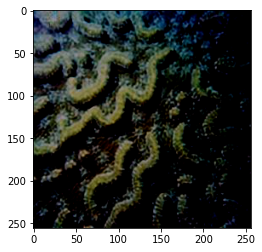

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


======================= J_Centered ====================


KeyboardInterrupt: ignored

In [ ]:

#import pytorch_ssim
def get_ut(clear_image) :
  #unpacked= torch.reshape(image,(3,image.shape[0]*image.shape[1]))
  
  ugt = torch.mean(clear_image, dim=(2,3), keepdim=True)
  # print('ugt.shape',ugt.shape)
  # ugt= torch.reshape(ugt,(1,3))

  return ugt

#ssim_loss = pytorch_ssim.SSIM(window_size = 11)
#ssim_index = ssim(J_gt, J_final)

ssim_loss = SSIM(window_size=11)
def loss_avg(ugt,ui) :
  ugt = torch.squeeze(ugt)
  ui = torch.squeeze(ui)
  return 1 -(torch.dot(ugt,ui))/(torch.norm(ugt).item()*torch.norm(ui).item())



def net_loss(J_gt, J_final, ugt, ui):
  total_loss =  1 - ssim(J_gt, J_final) + alpha*loss_avg(ugt, ui)
  return total_loss



n_total_steps = len(train_loader)
#device = torch.device("cuda:0")
for epoch in range(num_epochs):
    for i, (input_image, clear_image) in enumerate(train_loader):
        
        input_image = input_image.to(device)
        clear_image = clear_image.to(device)

        # Forward pass
        
        outputs = model(input_image)
       # loss = criterion(outputs, labels)
        #print(clear_image.shape)
        loss = net_loss(outputs,clear_image,get_ut(outputs),get_ut(clear_image))
        #print(i," ",loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)



In [ ]:
import torch 
torch.utils.backcompat.broadcast_warning.enabled=True
a = torch.randn(4,4,3,1)
mean = torch.mean(a, (0,1))
#print(mean,'\n', a)
print(mean.size(), a.size())
centered_a = a.sub_(mean)
print(centered_a.size())
#print('\n',centered_a)

In [ ]:
!pwd
#import pytorch_ssim
import torch
from torch.autograd import Variable

img1 = Variable(torch.rand(1, 1, 256, 256))
img2 = Variable(torch.rand(1, 1, 256, 256))

if torch.cuda.is_available():
    img1 = img1.cuda()
    img2 = img2.cuda()

print(pytorch_ssim.ssim(img1, img2))

ssim_loss = pytorch_ssim.SSIM(window_size = 11)

print(ssim_loss(img1, img2))